# 1 IMPORTS

In [29]:
import pandas as pd
import numpy as np
import inflection
from scipy.stats import skew, kurtosis, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree     import DecisionTreeRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
import xgboost as xgb
import pickle
import random

warnings.simplefilter(action='ignore', category=FutureWarning)


from IPython.core.display import HTML
from IPython.display import Image

## 1.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.set_option('display.max_columns', None)
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error(y, yhat, model_name):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        test_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        test_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        train = x_training[x_training['date'] <  test_start_date]
        test = x_training[(x_training['date'] >= test_start_date) & (x_training['date'] <= test_end_date)]

        # training and validation dataset
        # training
        x_train = train.drop( ['date', 'sales'], axis=1 ) 
        y_train = train['sales']

        # validation
        x_test = test.drop( ['date', 'sales'], axis=1 )
        y_test = test['sales']

        # model
        trained_model = model.fit( x_train, y_train )

        # prediction
        yhat = trained_model.predict( x_test )

        # performance
        model_result = ml_error( np.expm1( y_test ), np.expm1( yhat ), model_name )

        # store performance of each kfold iteration
        mae_list.append(  model_result['MAE'] )
        mape_list.append( model_result['MAPE'] )
        rmse_list.append( model_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/rafael/Downloads/portfolio/Sales-Prediction/.SalesPredictionEnv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.2 Loading data

In [4]:
#Two different files, store has the information about promotions, etc. 
#Sales reports the sales of each store day by day in a ~2 year interval

df_raw_store = pd.read_csv('../data/store.csv', low_memory=False)
df_raw_sales = pd.read_csv('../data/train.csv', low_memory=False)

df_raw = pd.merge(df_raw_store, df_raw_sales, how='left', on='Store')

In [5]:
df_raw[df_raw['Store']==1115]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016267,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2015-07-31,8680,538,1,1,0,1
1016268,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2015-07-30,8405,502,1,1,0,1
1016269,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2015-07-29,7661,473,1,1,0,1
1016270,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",2,2015-07-28,8093,500,1,1,0,1
1016271,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",1,2015-07-27,10712,608,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


# 2 DATA DESCRIPTION

In [6]:
df2 = df_raw.copy()
df2

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


## 2.1 Rename Columns

In [7]:
#i will be using snakecase for this project, so might turn it a standard

cols = df2.columns
snakecase_function = lambda x: inflection.underscore( x )
cols_new = list( map(snakecase_function, cols) )
df2.columns = cols_new
df2 = df2.rename(columns={'promo_interval':'promo2_interval'})

df2

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


## 2.2 Data Dimensions

In [9]:
print(f'Number of lines: {df2.shape[0]}')
print(f'Number of columns: {df2.shape[0]}')

Number of lines: 1017209
Number of columns: 1017209


## 2.3 Data Types

In [10]:
#need to fill NA before changing datatypes
df2.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo2_interval                  object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

In [11]:
#I am doing this here because i will need it for filling NA, otherwise it would be on change data types section
df2['date'] = pd.to_datetime( df2['date'] )

## 2.4 Check NA

In [12]:
df2.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo2_interval                 508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 2.5 Fillout NA

In [13]:
df2.describe()

,store,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,sales,customers,open,promo,school_holiday
count,"1,017,209.00","1,014,567.00","693,861.00","693,861.00","1,017,209.00","509,178.00","509,178.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00"
mean,558.43,"5,430.09",7.22,"2,008.69",0.50,23.27,"2,011.75",4.00,"5,773.82",633.15,0.83,0.38,0.18
std,321.91,"7,715.32",3.21,5.99,0.50,14.10,1.66,2.00,"3,849.93",464.41,0.38,0.49,0.38
min,1.00,20.00,1.00,"1,900.00",0.00,1.00,"2,009.00",1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,710.00,4.00,"2,006.00",0.00,13.00,"2,011.00",2.00,"3,727.00",405.00,1.00,0.00,0.00
50%,558.00,"2,330.00",8.00,"2,010.00",1.00,22.00,"2,012.00",4.00,"5,744.00",609.00,1.00,0.00,0.00
75%,838.00,"6,890.00",10.00,"2,013.00",1.00,37.00,"2,013.00",6.00,"7,856.00",837.00,1.00,1.00,0.00
max,"1,115.00","75,860.00",12.00,"2,015.00",1.00,50.00,"2,015.00",7.00,"41,551.00","7,388.00",1.00,1.00,1.00


In [14]:
# competition_distance - set a distance 4 times bigger than the max value when there is no competition
df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 300000 if np.isnan( x ) else x )

# competition_open_since_month - The idea to deal with those variables is 
# to say there are zero days since competition opened, I just set those to be equal to the date
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month 
                                                if np.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year 
                                               if np.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis=1)

# promo2_since_week

df2['promo2_since_week'] = df2.apply( lambda x: x['date'].week 
                                     if np.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year 
                                     if np.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

# promo_interval - we can just set to 0 when there is no promo
df2['promo2_interval'].fillna(0, inplace=True)

#now I need a feature that describes whether the store is in promo2 or not since those infos are in different files
# promo2 column just says if the store participates or not in promo2, not if it is active
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
month_map = {i+1: months[i] for i in range(12)}

df2['date_month'] = df2['date'].dt.month.map( month_map )

df2['is_promo2'] = df2[['date_month', 'promo2_interval']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                               1 if x['date_month'] in x['promo2_interval'].split(',') 
                                                               else 0, axis=1 )

## 2.6 Change Data Types

In [15]:
df2 = df2.astype( {'competition_open_since_month':'int64',
            'competition_open_since_year':'int64',
            'promo2_since_week':'int64',
            'promo2_since_year':'int64'} ) 
df2.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo2_interval                         object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
date_month                              object
is_promo2                                int64
dtype: object

## 2.7 Descriptive Statistics

In [16]:
num_attributes = df2.select_dtypes(include=['float64','int64'])
cat_attributes = df2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])

### 2.7.1 Numerical Atributes

In [17]:
#attributes to evaluate: mean, median, std, min, max, range, skew, kurtosis

d1 = np.mean(num_attributes)
d2 = pd.Series(np.median(num_attributes, axis=0), index=d1.index)
d3 = np.std(num_attributes)
d4 = np.min(num_attributes)
d5 = np.max(num_attributes)
d6 = d5-d4
d7 = pd.Series( skew(num_attributes), index= d1.index)
d8 = pd.Series( kurtosis(num_attributes), index= d1.index)

df_description = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8], axis=1)
df_description.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [18]:
# quick statistical remark: skew means there is a tail to the right(positive) or the left(negative)
# kurtosis means it is sharper (>>0) or broader(<<0) than normal distribution

df_description

,mean,median,std,min,max,range,skew,kurtosis
store,558.43,558.00,321.91,1.00,"1,115.00","1,114.00",-0.00,-1.20
competition_distance,"6,195.17","2,330.00","16,856.98",20.00,"300,000.00","299,980.00",14.00,237.34
competition_open_since_month,6.79,7.00,3.31,1.00,12.00,11.00,-0.04,-1.23
competition_open_since_year,"2,010.32","2,012.00",5.52,"1,900.00","2,015.00",115.00,-7.24,124.07
promo2,0.50,1.00,0.50,0.00,1.00,1.00,-0.00,-2.00
promo2_since_week,23.62,22.00,14.31,1.00,52.00,51.00,0.18,-1.18
promo2_since_year,"2,012.79","2,013.00",1.66,"2,009.00","2,015.00",6.00,-0.78,-0.21
day_of_week,4.00,4.00,2.00,1.00,7.00,6.00,0.00,-1.25
sales,"5,773.82","5,744.00","3,849.92",0.00,"41,551.00","41,551.00",0.64,1.78
customers,633.15,609.00,464.41,0.00,"7,388.00","7,388.00",1.60,7.09


### 2.7.2 Categorical Atributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0], axis=0)

store_type          4
assortment          3
promo2_interval     4
state_holiday       4
date_month         12
dtype: int64

In [20]:
df2[df2['state_holiday'] != '0'].head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,date_month,is_promo2
57,1,c,a,"1,270.00",9,2008,0,23,2015,0,4,2015-06-04,0,0,0,1,a,0,Jun,0
67,1,c,a,"1,270.00",9,2008,0,22,2015,0,1,2015-05-25,0,0,0,0,a,0,May,0
78,1,c,a,"1,270.00",9,2008,0,20,2015,0,4,2015-05-14,0,0,0,0,a,0,May,0
91,1,c,a,"1,270.00",9,2008,0,18,2015,0,5,2015-05-01,0,0,0,1,a,0,May,0
116,1,c,a,"1,270.00",9,2008,0,15,2015,0,1,2015-04-06,0,0,0,0,b,1,Apr,0


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

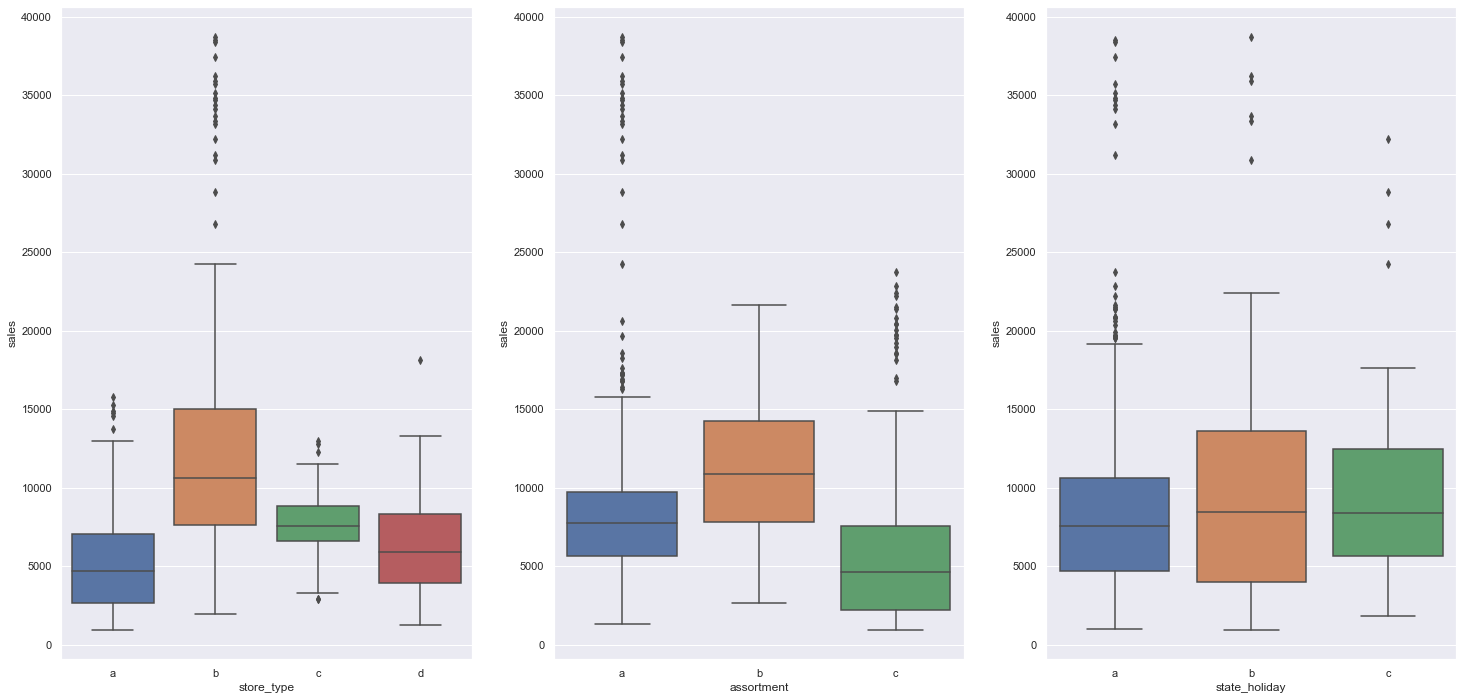

In [21]:
aux1 = df2[(df2['state_holiday'] != '0') & (df2['sales'] > 0) & (df2['state_holiday'] != 0)]

plt.subplot(1,3,1)
sns.boxplot(x='store_type', y='sales', data=aux1.sort_values(by='store_type'))

plt.subplot(1,3,2)
sns.boxplot(x='assortment', y='sales', data=aux1.sort_values(by='assortment'))

plt.subplot(1,3,3)
sns.boxplot(x='state_holiday', y='sales', data=aux1.sort_values(by='state_holiday'))

# 3 FEATURE ENGINEERING

In [22]:
df3 = df2.copy()

## 3.1 Hypothesis Mindmap

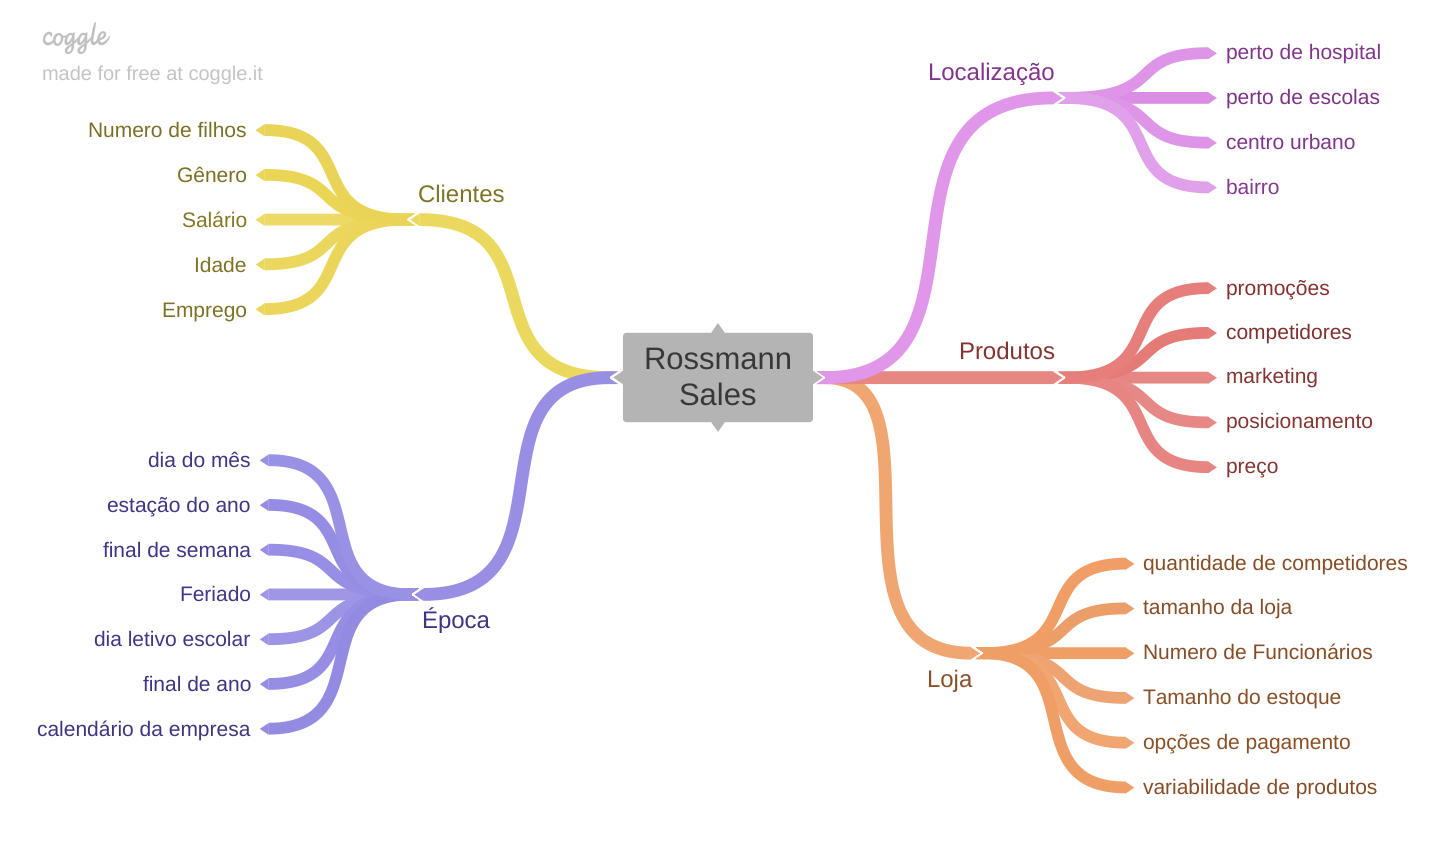

In [23]:
Image('../img/coggle_mindmap.png')

In [24]:
df3.head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,date_month,is_promo2
0,1,c,a,"1,270.00",9,2008,0,31,2015,0,5,2015-07-31,5263,555,1,1,0,1,Jul,0
1,1,c,a,"1,270.00",9,2008,0,31,2015,0,4,2015-07-30,5020,546,1,1,0,1,Jul,0
2,1,c,a,"1,270.00",9,2008,0,31,2015,0,3,2015-07-29,4782,523,1,1,0,1,Jul,0
3,1,c,a,"1,270.00",9,2008,0,31,2015,0,2,2015-07-28,5011,560,1,1,0,1,Jul,0
4,1,c,a,"1,270.00",9,2008,0,31,2015,0,1,2015-07-27,6102,612,1,1,0,1,Jul,0


In [25]:
df3['competition_open_since_year']

0          2008
1          2008
2          2008
3          2008
4          2008
           ... 
1017204    2013
1017205    2013
1017206    2013
1017207    2013
1017208    2013
Name: competition_open_since_year, Length: 1017209, dtype: int64

## 3.2 Business Hypothesis

- Sales should be uniform along the month (since Rosmmann is a drug store); 
- Sales should inccrease in the european winter;
- Sales should increase in promo days;
- Extended assortment stores should sell more;
- Multiple promotions should be better than just one;
- Sales should decrease with new competition opening;
- Closer competitors should decrease sales;
- there should be no difference between sales in holidays or regular days.



## 3.4 Feature Engineering

In [26]:
# # Now I will engineer the features necessary for checking the business hypothesis

# #first separate the date in day week, month, year

df3['year'] = df3['date'].dt.year

df3['day'] = df3['date'].dt.day

df3['weekofyear'] = df3['date'].dt.isocalendar().week

df3['month'] = df3['date'].dt.month

df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# recency of competition

df3['competition_open_date'] = df3[['competition_open_since_month', 'competition_open_since_year']].apply(
                            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

df3['competition_open_since'] = (df3['date'] - df3['competition_open_date']).dt.days


#since when there is the store under promo2
df3['promo2_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo2_since'] = df3['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df3['promo2_since_in_week'] = ( ( df3['date'] - df3['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( int )


# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 4 DATA FILTERING

In [27]:
df4 = df3.copy()

## 4.1 Filter Rows

In [28]:
#I want to predict only when the store will actually have sales

df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

## 4.2 Filter Columns

In [29]:
#avoid data leakage and redundant information

df4.columns

cols_to_drop = ['customers', 'open', 'promo2_interval', 'date_month']

df4 = df4.drop(cols_to_drop, axis = 1)

# 5 EXPLORATORY DATA ANALYSIS

In [30]:
df5 = df4.copy() 

## 5.1 Univariate Analysis

### 5.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

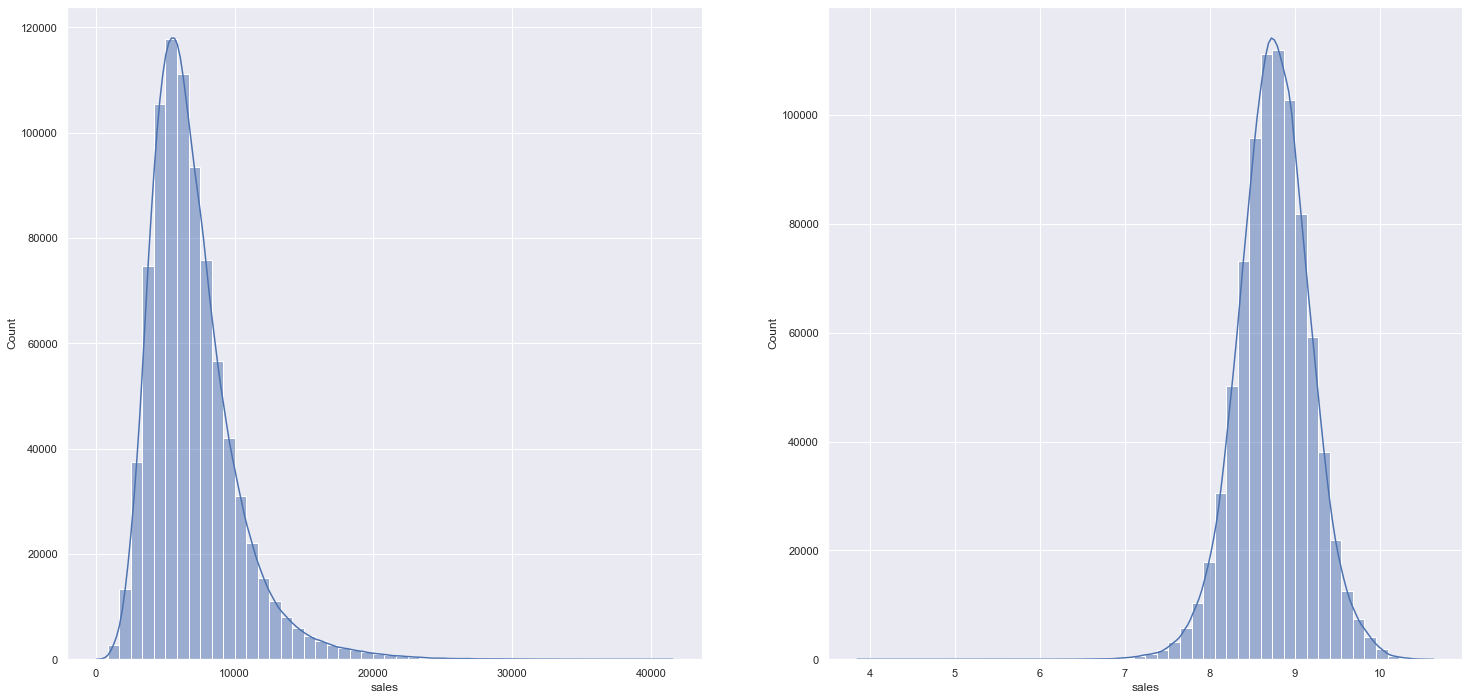

In [31]:
plt.figure()

plt.subplot(1,2,1)
sns.histplot(df5['sales'], bins=50, kde=True)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df5['sales']), bins=50, kde=True)

#The log transformation approximates the response variable more to a normal distribution (no tail, lower skew),
# therefore it should lower the error

### 5.1.2 Numerical Variable

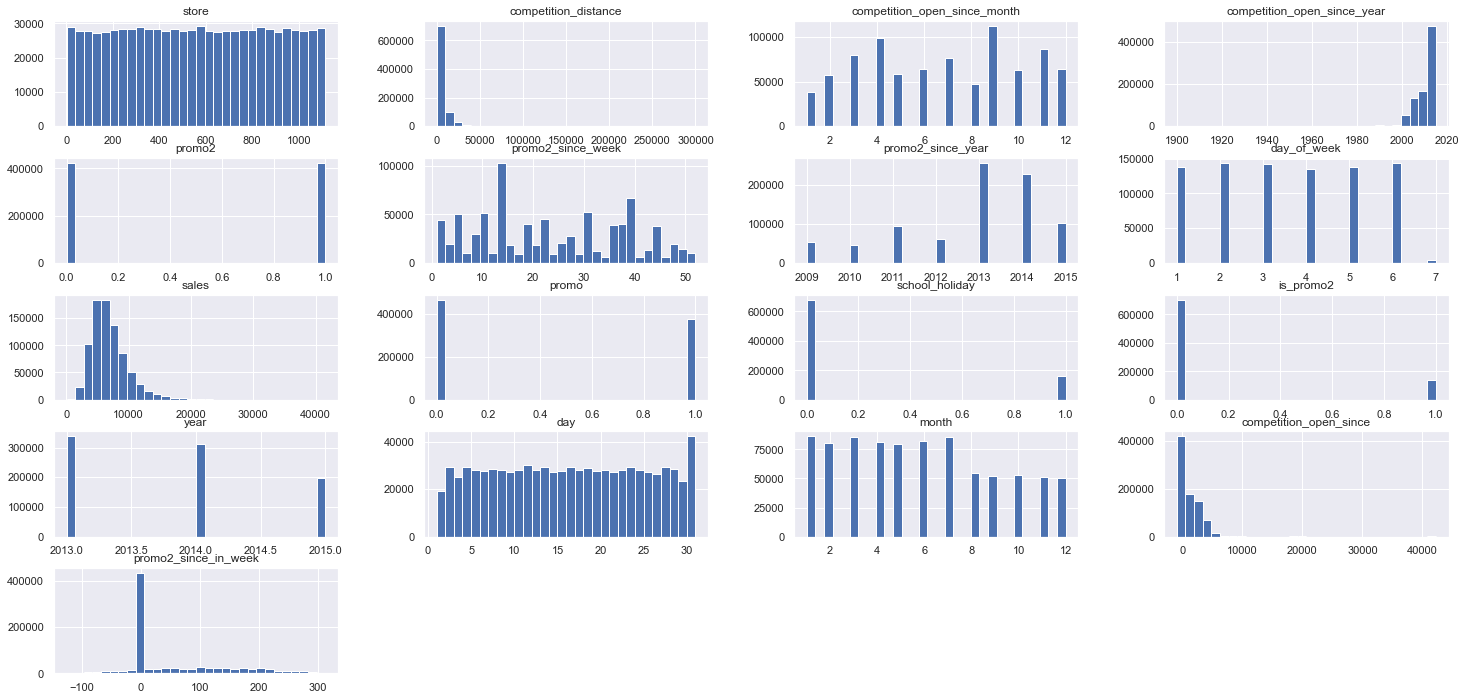

In [32]:
num_attributes = df5.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=30);

### 5.1.3 Categorical Variable

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

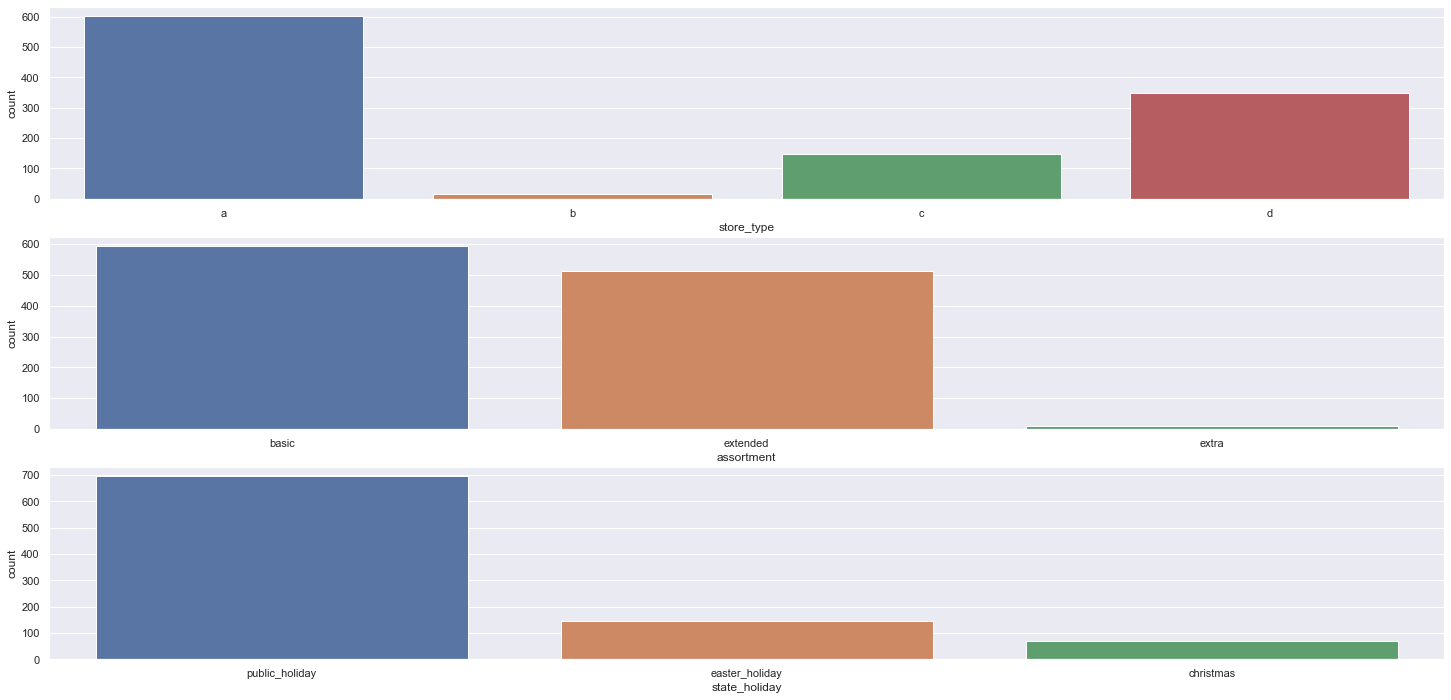

In [33]:
categorical_attributes = df5[['store','store_type','assortment','state_holiday']]
aux1 = categorical_attributes.groupby('store').agg(lambda x:x.value_counts().index[0])

plt.subplot(3, 1, 1)
sns.countplot( x='store_type', data=aux1.sort_values(by=['store_type','assortment','state_holiday']))

plt.subplot(3, 1, 2)
sns.countplot( x='assortment', data=aux1.sort_values(by=['store_type','assortment','state_holiday']))

plt.subplot(3, 1, 3)
sns.countplot( x='state_holiday', data=categorical_attributes[categorical_attributes['state_holiday'] != 'regular_day'])

## 5.2 Bivariate Analysis

The amount of information that could be drawn from this section is enormous thus I will choose to analyze only the hypothesis I stated in section 3.2

### H1 Sales should be uniform along the month (since Rosmmann is a drug store)
**FALSE** Sales can vary up to \$2000 per day due to the day of the month

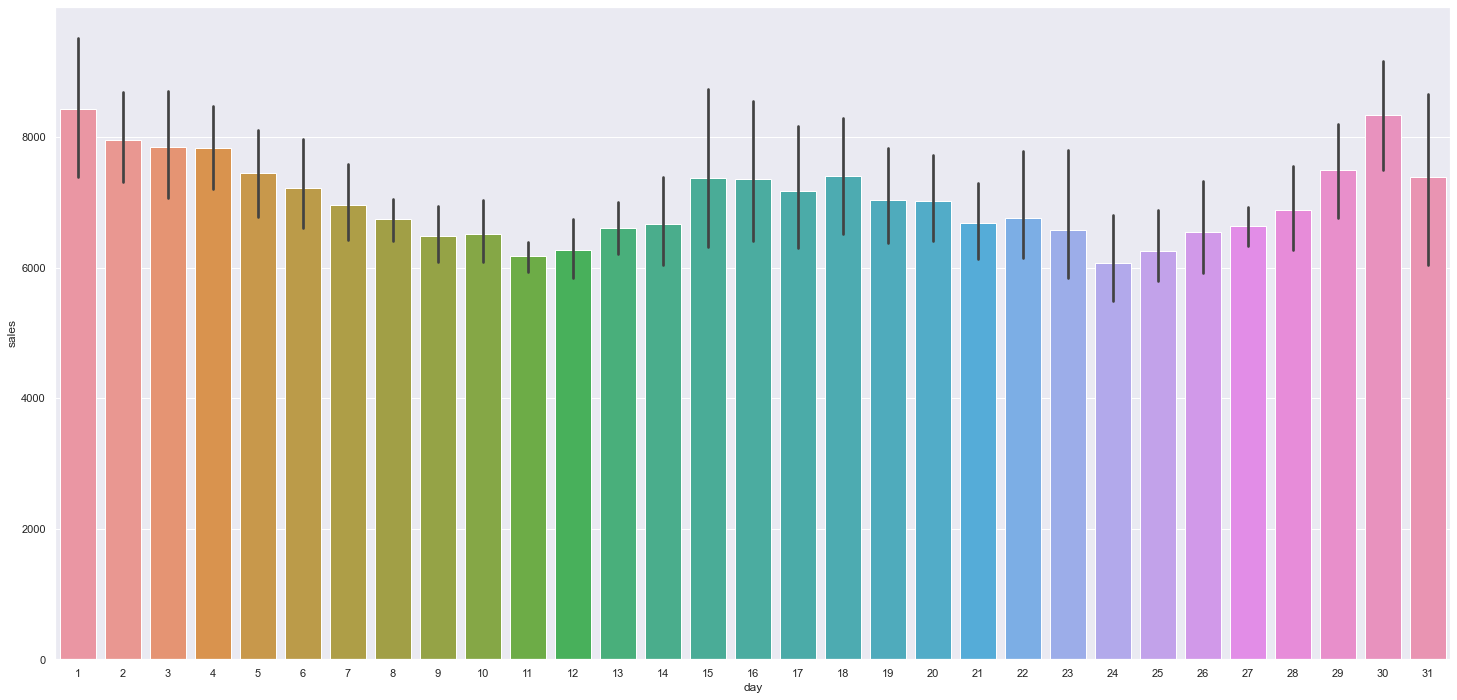

In [34]:
#sales are actually bigger close to day 1 and day 15, maybe because of payment?

aux1 = df5[['sales','month','day']].groupby(['day', 'month']).mean().reset_index()

sns.barplot(x='day',y='sales', data=aux1);

### H2 Sales should inccrease in the european winter
**FALSE** the sales during winter represent about the same percentage than other seasons

In [35]:
winter_sales = df5[((df5['day'] >= 21) & (df5['month'] == 12)) | (df5['month'] < 3) | ((df5['month'] == 3) & (df5['day'] < 20))]['sales'].sum()
pct_winter_sales=(winter_sales/df5['sales'].sum()) * 100

print(f'The sales on winter represent {pct_winter_sales:.2f}% of the total sales' )

The sales on winter represent 26.85% of the total sales


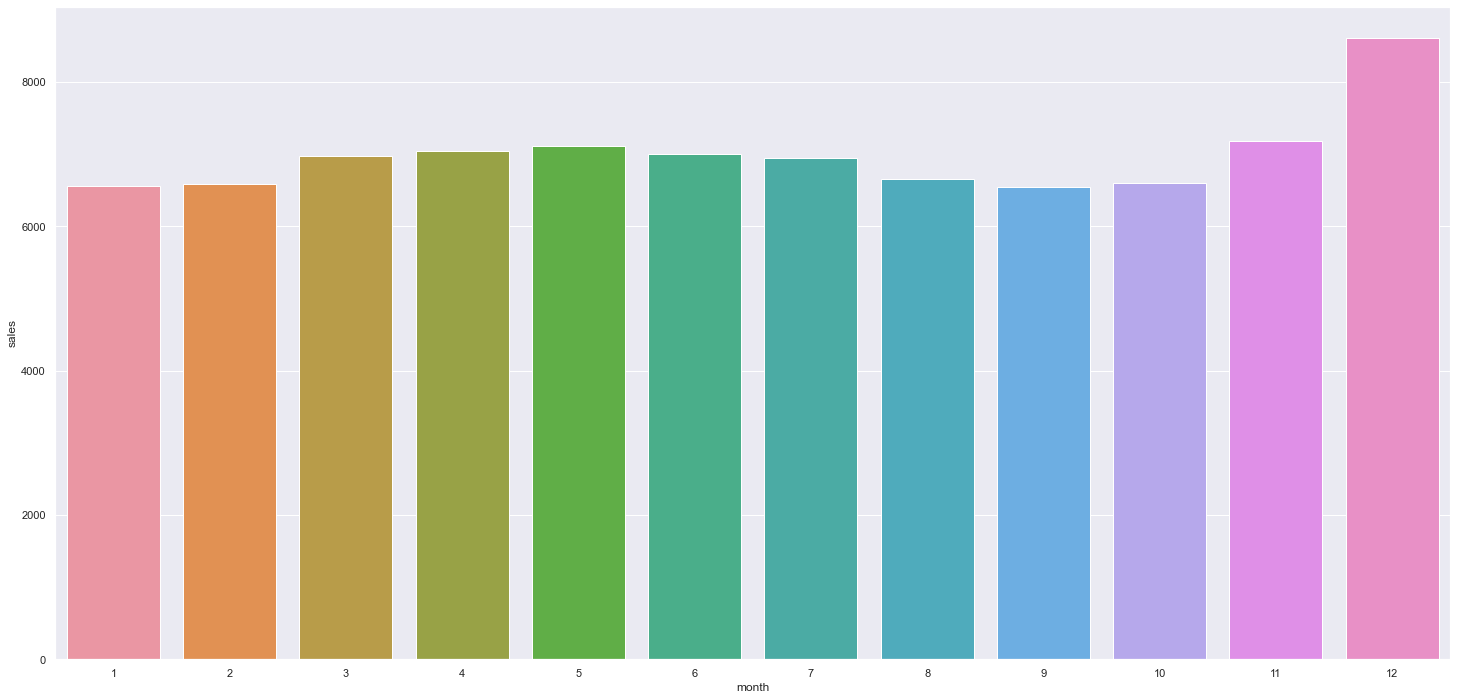

In [36]:
aux1 = df5[['month','sales']].groupby('month').mean().reset_index()

sns.barplot(x='month',y='sales',data= aux1 );

### H3 Sales should increase in promo days;
**True** for promo1 and **False** for Promo2

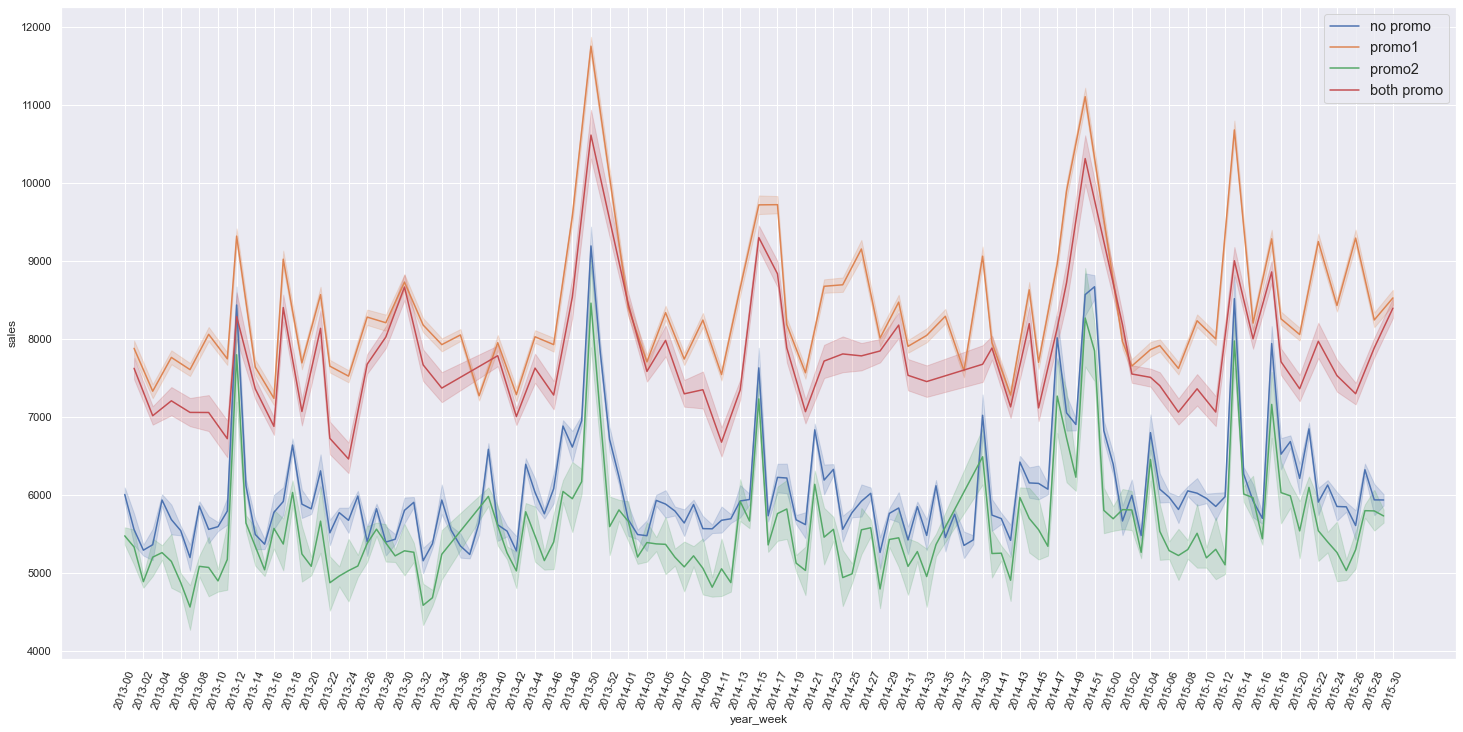

In [37]:
aux1 = df5[['sales','year_week','promo','is_promo2']].sort_values(by='year_week')

sns.lineplot(data=aux1[(aux1['promo'] == 0) & (aux1['is_promo2']==0)],x='year_week', y='sales', label='no promo');
sns.lineplot(data=aux1[(aux1['promo'] == 1) & (aux1['is_promo2']==0)],x='year_week', y='sales', label='promo1' );
sns.lineplot(data=aux1[(aux1['promo'] == 0) & (aux1['is_promo2']==1)],x='year_week', y='sales', label='promo2' );
sns.lineplot(data=aux1[(aux1['promo'] == 1) & (aux1['is_promo2']==1)],x='year_week', y='sales', label='both promo' );

plt.legend(fontsize='large');
plt.xticks(np.arange(0, len(aux1['year_week'].unique()), 2), rotation=70);

### H4 Extended assortment stores should sell more;
**True**: The more extended the assortments, greater are the sales

<AxesSubplot:xlabel='year_week'>

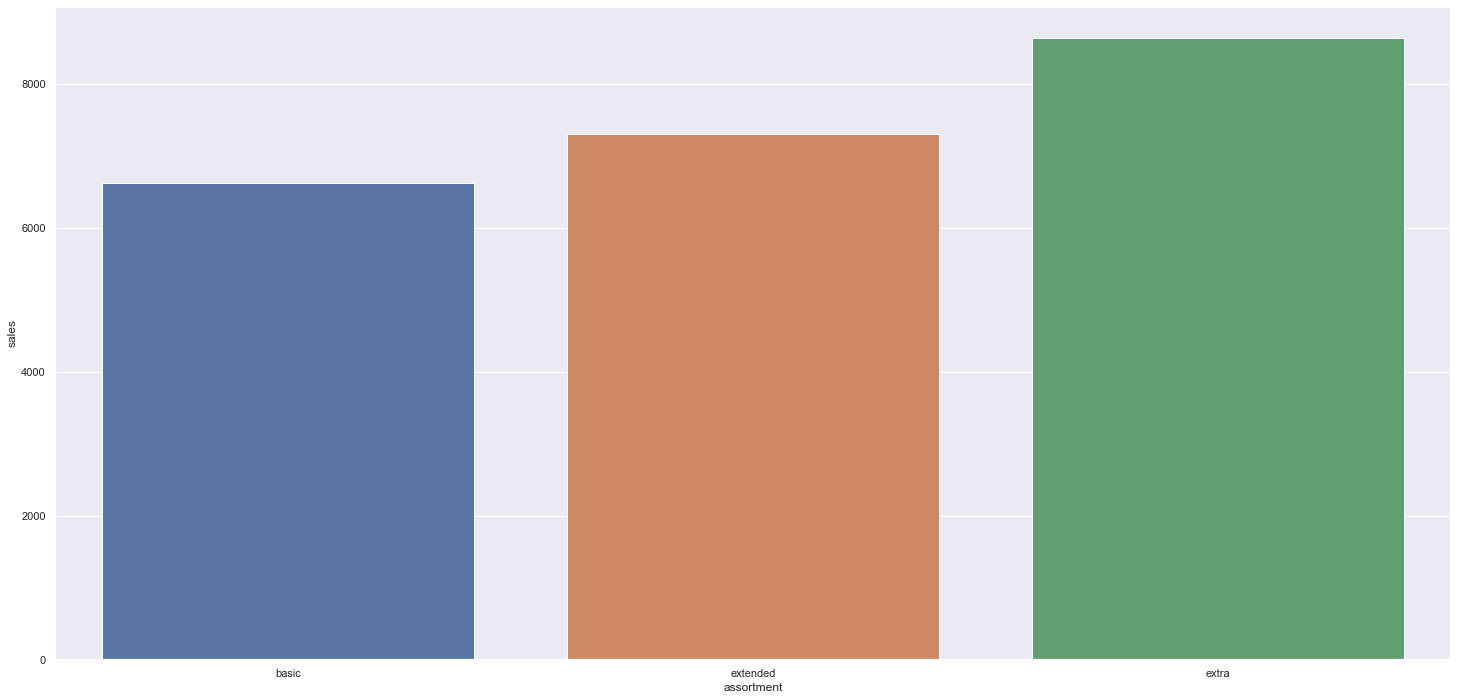

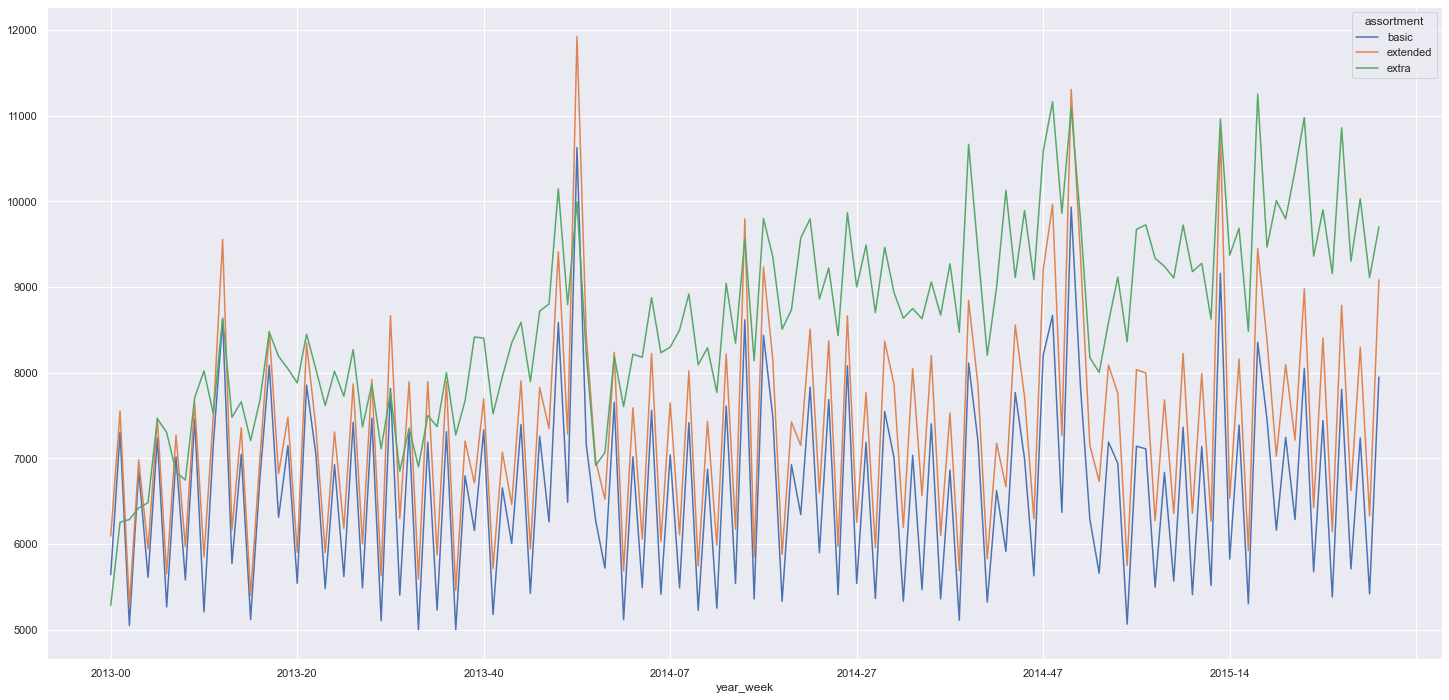

In [38]:
aux1 = df5[['sales', 'year_week','assortment']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2 = df5[['sales', 'year_week','assortment']].groupby('assortment').mean().reset_index()

sns.barplot(x='assortment',y='sales',data=aux2)
aux1.pivot(index='year_week', columns='assortment', values='sales').plot()

### H5 Multiple promotions should be better than just one;
**False** Promo1 is better alone than along with promo2 (check hypothesis 3)

### H6 Sales should decrease with new competition opening;
**True** Sales decrease with competition opening

<AxesSubplot:xlabel='competition_open_since', ylabel='sales'>

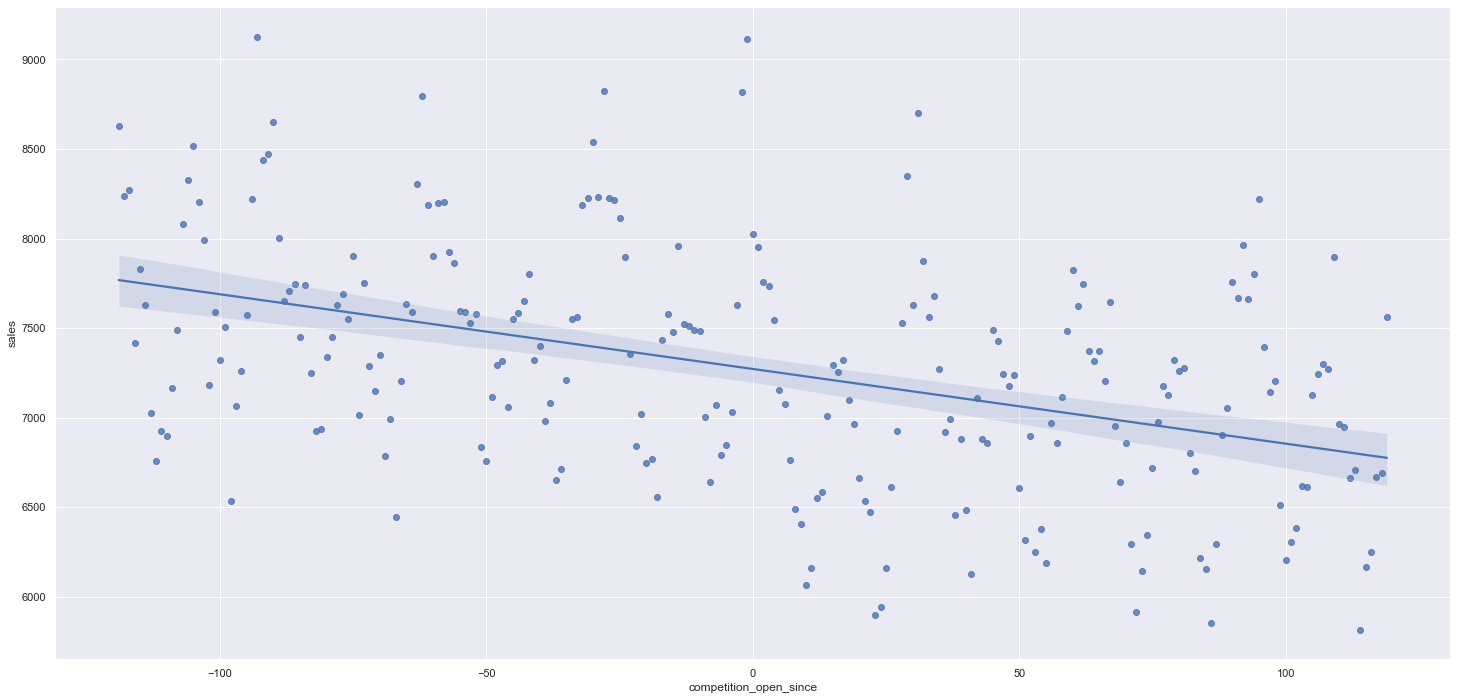

In [39]:
aux1 = df5[['sales', 'competition_open_since']]
aux1 = aux1[(aux1['competition_open_since'] < 120) & ((aux1['competition_open_since'] > -120))].groupby('competition_open_since').mean().reset_index()

sns.regplot(x='competition_open_since',y='sales',data=aux1)

### H7 Closer competitors should decrease sales;
**False** The average impact is not affected by the distance of competitors

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

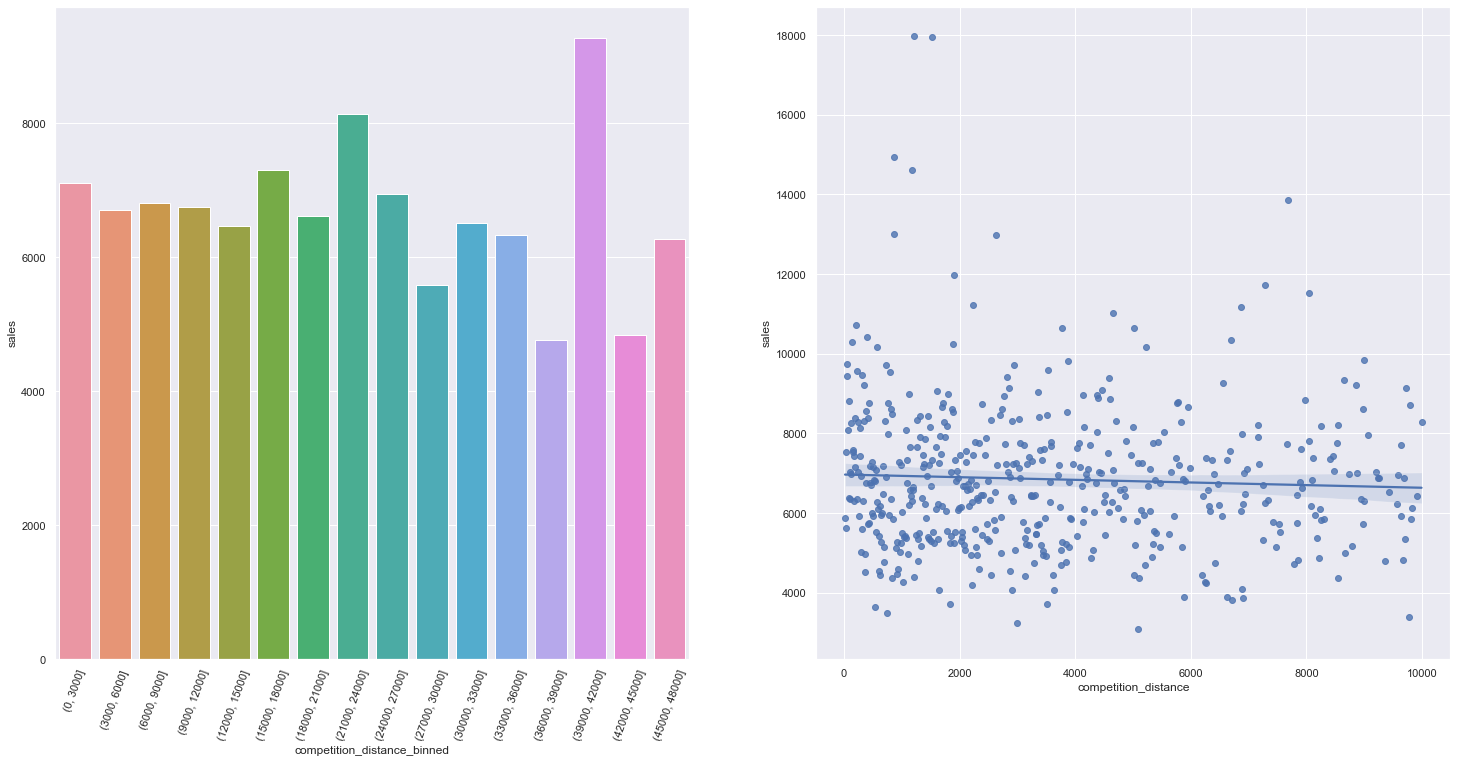

In [40]:
bins = list( np.arange( 0, 50000, 3000) )
aux1 = df5[['sales', 'competition_distance']].copy()
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux1 = aux1.groupby('competition_distance_binned').mean().reset_index()

plt.subplot(1,2,1)
plt.xticks(rotation=70)
sns.barplot(x='competition_distance_binned',y='sales',data=aux1)

aux2 = df5[['sales', 'competition_distance']].groupby('competition_distance').mean().reset_index()
aux2 = aux2[aux2['competition_distance'] < 10000]

plt.subplot(1,2,2)
sns.regplot(x='competition_distance',y='sales',data=aux2)

### H8 There should be no difference between sales in holidays or regular days.
**False** Stores sell more in holidays than on normal days

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

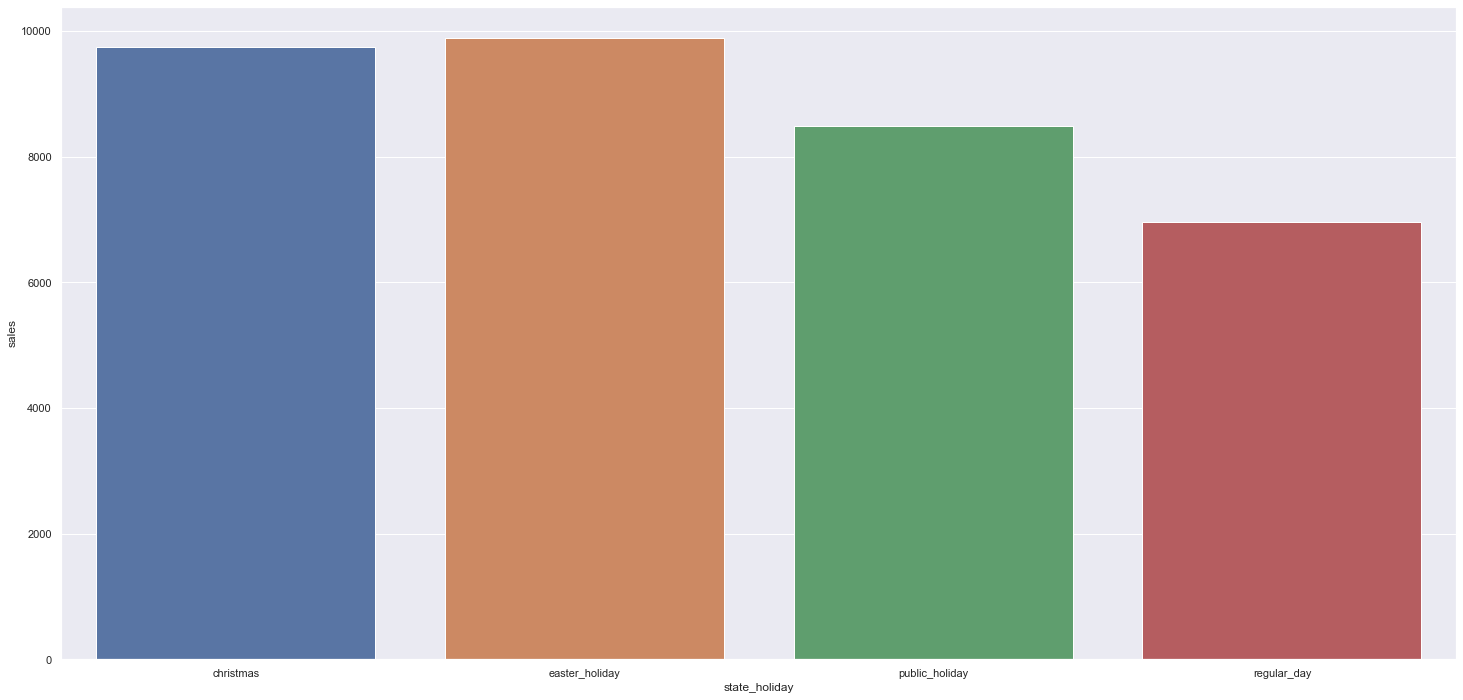

In [41]:
aux1 = df5[['sales', 'state_holiday']].groupby('state_holiday').mean().reset_index()
sns.barplot( x='state_holiday',y='sales',data=aux1)

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

<AxesSubplot:>

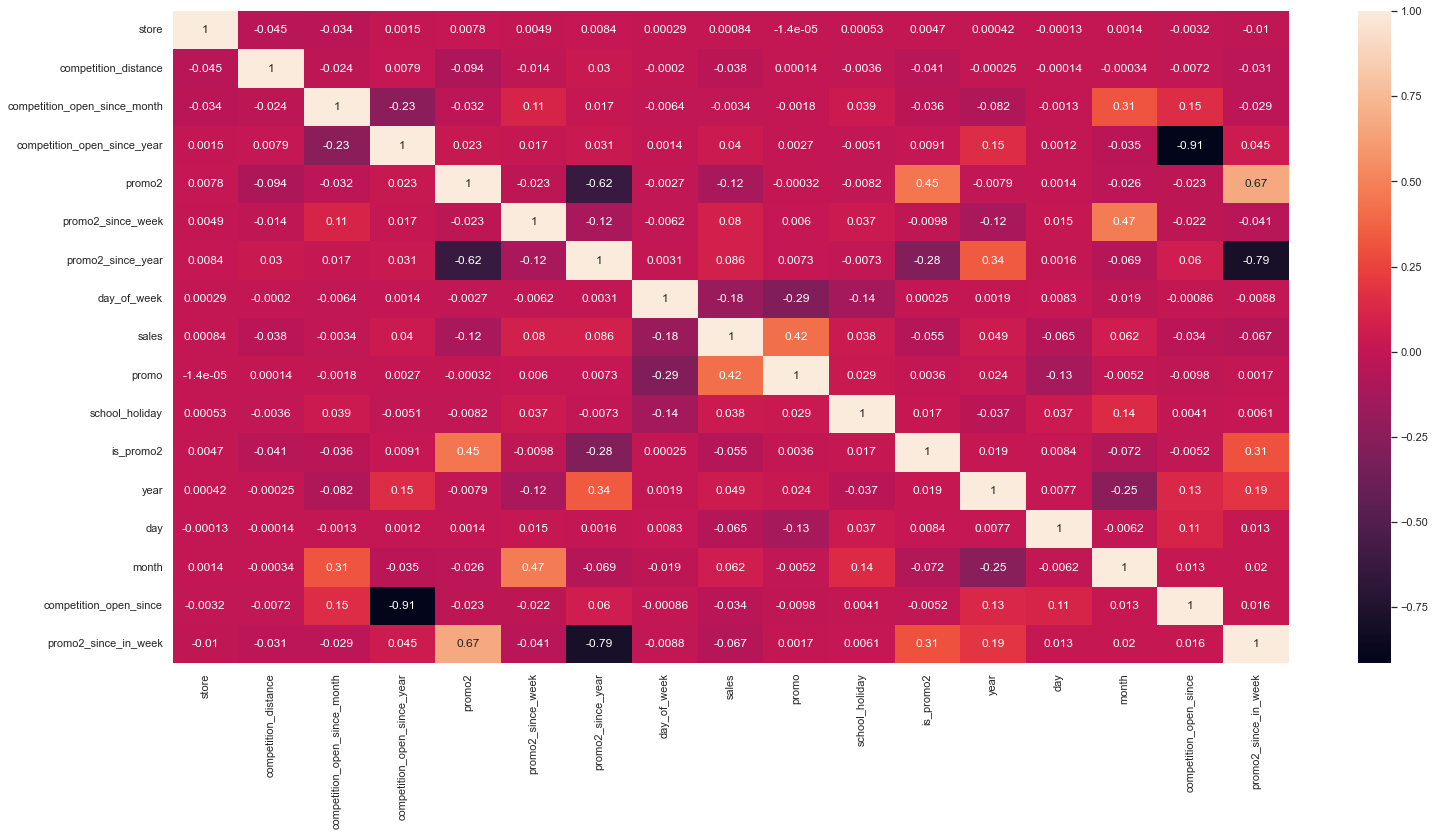

In [42]:
num_attributes = df5.select_dtypes(include=['float64', 'int64'])
num_correlations = num_attributes.corr(method='spearman')
sns.heatmap(num_correlations, annot=True)

### 5.3.2 Categorical Attributes

<AxesSubplot:>

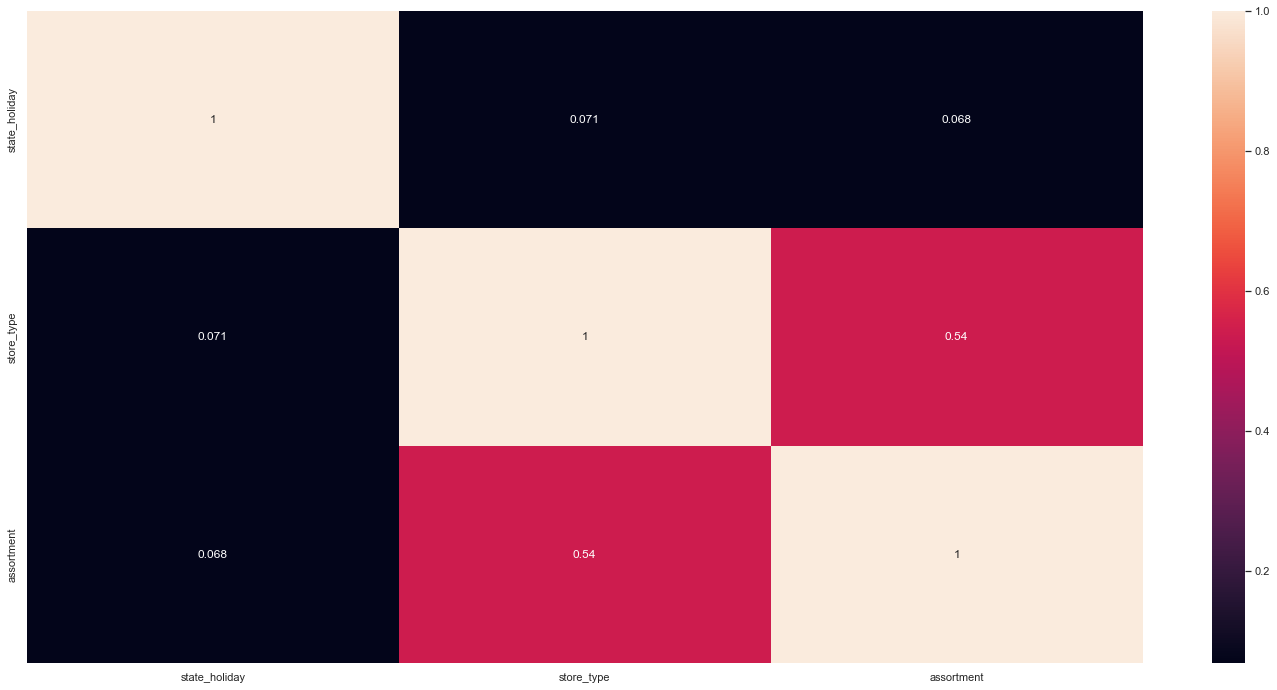

In [43]:
# cramer V is the main metric for correlation of categorical attributes
categorical_attributes = df5.select_dtypes(include='object')
categorical_attributes = categorical_attributes.drop(columns=['year_week'])

a1 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['state_holiday'] )
a2 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['store_type'] )
a3 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['assortment'] )

a4 = cramer_v( categorical_attributes['store_type'], categorical_attributes['state_holiday'] )
a5 = cramer_v( categorical_attributes['store_type'], categorical_attributes['store_type'] )
a6 = cramer_v( categorical_attributes['store_type'], categorical_attributes['assortment'] )

a7 = cramer_v( categorical_attributes['assortment'], categorical_attributes['state_holiday'] )
a8 = cramer_v( categorical_attributes['assortment'], categorical_attributes['store_type'] )
a9 = cramer_v( categorical_attributes['assortment'], categorical_attributes['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 6 DATA PREPARATION

In [90]:
df6 = df5.copy()

## 6.1 Normalization

In [91]:
#This is for applying StandardScaler, but since it only applies to variables 
#with normal distributions this section will remain empty

## 6.2 Rescaling

<AxesSubplot:xlabel='promo2_since_in_week'>

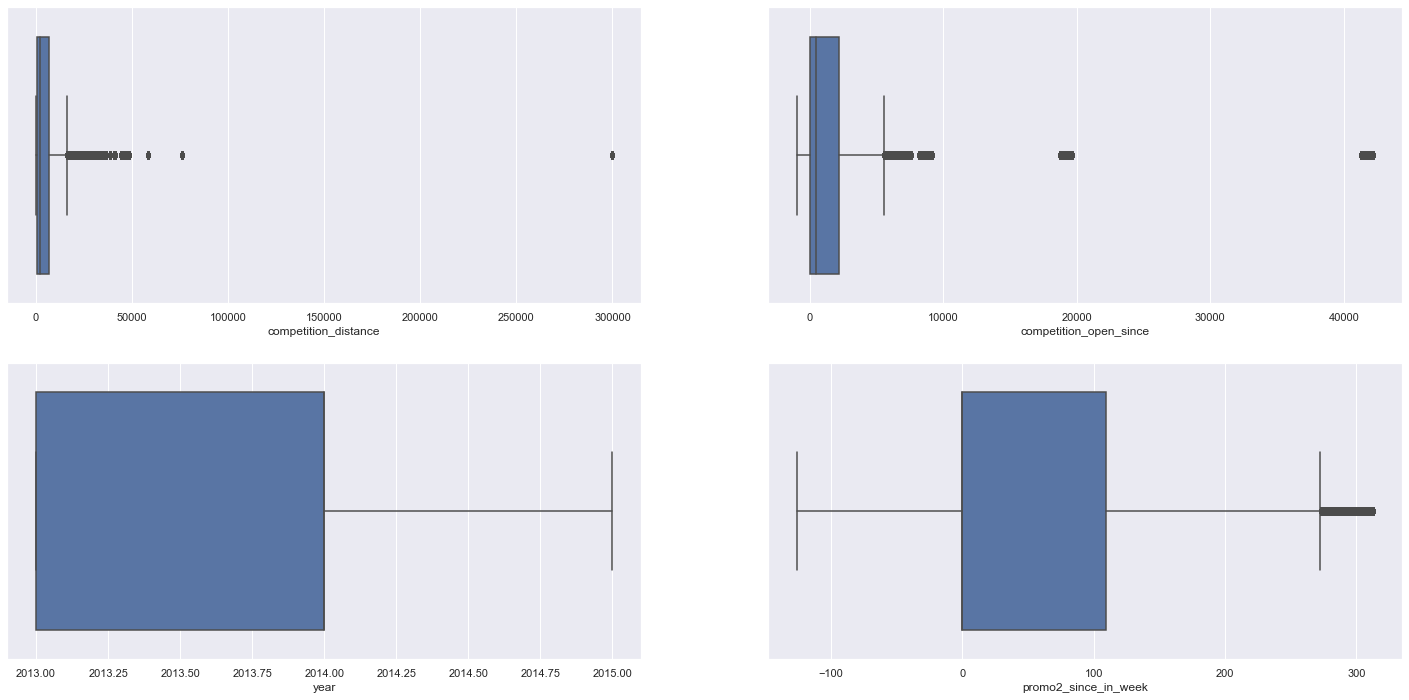

In [92]:
plt.subplot(2, 2, 1)
sns.boxplot(df6['competition_distance'])

plt.subplot(2, 2, 2)
sns.boxplot(df6['competition_open_since'])

plt.subplot(2, 2, 3)
sns.boxplot(df6['year'])

plt.subplot(2, 2, 4)
sns.boxplot(df6['promo2_since_in_week'])

In [93]:
#twwo methods were used at this point. minmax and robust scalers.
#Robust scaler was used for variables with very significative outliers, and minmax otherwise

rs = RobustScaler()
mms = MinMaxScaler()

# variables to rescale
# 'competition_distance','competition_open_since', 'year', 'promo2_since_in_week'
#according to boxplot, competition_distance and competition_open_since need robust scaler

df6['competition_distance'] = rs.fit_transform( df6[['competition_distance']].values )
pickle.dump(rs, open('competition_distance_scale.pkl', 'wb'))

df6['competition_open_since'] = rs.fit_transform( df6[['competition_open_since']].values )
pickle.dump(rs, open('competition_open_since_scale.pkl', 'wb'))

df6['year']= mms.fit_transform( df6[['year']].values )
pickle.dump(mms, open('year_scale.pkl', 'wb'))

df6['promo2_since_in_week']= mms.fit_transform( df6[['promo2_since_in_week']].values )
pickle.dump(mms, open('promo2_since_in_week_scale.pkl', 'wb'))

## 6.3 Transformation

### 6.3.1 Encoding

In [94]:
#At this point, I did not find a good enough encoding for store, so I will let this task for the future
#

# 'store_type', 'assortment', state_holiday
df6 = pd.get_dummies( df6, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform( df6['store_type'] )
pickle.dump(le, open('store_type_encoder.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extended': 2, 'extra': 3}
df6['assortment'] = df6['assortment'].map( assortment_dict )

### 6.3.2 Response Variable Transformation

In [95]:
# 'sales'

df6['sales'] = np.log1p( df6['sales'] )

### 6.3.3 Nature Transformation

In [96]:
# day of week
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df6['week_of_year_sin'] = df6['weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['week_of_year_cos'] = df6['weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 7 FEATURE SELECTION

In [51]:
df7 = df6.copy()

## 7.1 Split dataframe into training and test dataset

In [52]:
cols_drop_model = [ 'competition_open_since_month', 'competition_open_since_year','competition_open_date',
                    'promo2_since_week','promo2_since', 'promo2_since_year', 'year', 'day','weekofyear', 
                    'month', 'year_week', 'day_of_week']

df7 = df7.drop(cols_drop_model, axis=1)

In [53]:
#In principle, this is a multivariate time series prediction. 
#Thus, I will need to separate the dataset chronologically

date_start_test = df7['date'].max() - datetime.timedelta(days=6*7)

train_data = df7[df7['date'] < date_start_test]
test_data  = df7[df7['date'] >= date_start_test]

## 7.2 Boruta as Feature Selector

In [54]:
# # training and test dataset for Boruta
# boruta_train_X = train_data.drop(['date', 'sales'], axis=1).values
# boruta_train_y = train_data['sales'].values


# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )
# # dtr = DecisionTreeRegressor()

# # define Boruta
# boruta = BorutaPy( rf, n_estimators=1, verbose=2, random_state=42 ).fit( boruta_train_X, boruta_train_y )

### 7.2.1 Best Features from Boruta

In [55]:
# cols_selected_boruta = boruta.support_.tolist()

# # best features
# cols_selected_boruta = train_data.drop(['date', 'sales'], axis=1).iloc[:,boruta.support_.tolist()].columns.tolist()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( train_data.drop(['date', 'sales'], axis=1).columns, cols_selected_boruta ) )

# cols_not_selected_boruta

## 7.3 Manual Feature Selection

In [56]:
cols_selected_model =[
 'store',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'promo',
 'competition_open_since',
 'promo2_since_in_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'sales',
 'date']

In [57]:
#define df for the model

df_train = train_data[cols_selected_model]
df_test =  test_data[cols_selected_model]

In [58]:
df_train

,store,store_type,assortment,competition_distance,promo2,promo,competition_open_since,promo2_since_in_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,sales,date
43,1,2,1,-0.17,0,1,0.89,0.29,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99,8.44,2015-06-18
44,1,2,1,-0.17,0,1,0.89,0.29,0.43,-0.90,0.00,-1.00,-0.41,-0.91,0.12,-0.99,8.29,2015-06-17
45,1,2,1,-0.17,0,1,0.89,0.29,0.97,-0.22,0.00,-1.00,-0.21,-0.98,0.12,-0.99,8.49,2015-06-16
46,1,2,1,-0.17,0,1,0.89,0.29,0.78,0.62,0.00,-1.00,0.00,-1.00,0.12,-0.99,8.62,2015-06-15
48,1,2,1,-0.17,0,0,0.89,0.29,-0.78,0.62,0.00,-1.00,0.41,-0.91,0.24,-0.97,8.36,2015-06-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,3,2,0.49,1,1,-0.23,0.36,0.78,0.62,0.50,0.87,0.99,0.10,0.24,0.97,8.84,2013-01-07
1017204,1115,3,2,0.49,1,0,-0.23,0.36,-0.78,0.62,0.50,0.87,0.87,0.50,0.12,0.99,8.47,2013-01-05
1017205,1115,3,2,0.49,1,0,-0.23,0.36,-0.97,-0.22,0.50,0.87,0.74,0.67,0.12,0.99,8.42,2013-01-04
1017206,1115,3,2,0.49,1,0,-0.23,0.36,-0.43,-0.90,0.50,0.87,0.59,0.81,0.12,0.99,8.37,2013-01-03


# 8 MACHINE LEARNING MODELLING

In [59]:
df8 = df_train.copy()

In [60]:
X_train = df_train.drop(['sales', 'date'], axis=1)
y_train = df_train['sales']
x_test  = df_test.drop(['sales', 'date'], axis=1)
y_test  = df_test['sales']

## 8.1 Average Model

In [65]:
mean_predictions = df8[['store','sales']].groupby('store').mean().rename(columns={'sales':'predictions'})
yhat_mean = pd.merge(x_test, mean_predictions, how='inner', on='store')['predictions']

ml_error(np.expm1( y_test), np.expm1(yhat_mean), 'mean' )

,Model Name,MAE,MAPE,RMSE
0,mean,"1,429.76",0.22,"1,939.33"


## 8.2 Linear Regression Model

In [66]:
lr = LinearRegression().fit( X_train, y_train )

yhat_lr = lr.predict( x_test )

ml_error(np.expm1( y_test), np.expm1(yhat_lr), 'Linear Regression' )

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,"1,870.60",0.28,"2,718.59"


### 8.2.1 Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation( df8, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2103.18 +/- 343.84,0.3 +/- 0.01,3015.54 +/- 529.33


## 8.3 Linear Regression Regularized Model - Lasso

In [68]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
ml_error( np.expm1( y_test ), np.expm1( yhat_lrr ), 'Linear Regression - Lasso' )

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,"1,900.32",0.29,"2,768.27"


###  8.3.1 Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation( df8, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2130.79 +/- 369.62,0.3 +/- 0.01,3068.09 +/- 551.47


## 8.4 Random Forest Regressor

In [70]:
# model
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
ml_error( np.expm1( y_test ), np.expm1( yhat_rf ), 'Random Forest Regressor')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,737.02,0.11,"1,129.09"


### 8.4.1 Random Forest Regressor - Cross Validation

In [71]:
rf_result_cv = cross_validation( df8, 5, 'Random Forest', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,913.09 +/- 268.03,0.13 +/- 0.03,1376.31 +/- 395.24


## 8.5 XGBoost Regressor

In [72]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=1000, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( X_train, y_train )

yhat_xgb = model_xgb.predict( x_test )

ml_error( np.expm1( y_test ), np.expm1( yhat_xgb ), 'XGBoost Regressor' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,980.04,0.14,"1,454.92"


### 8.5.1 XGBoost Regressor - Cross Validation

In [74]:
xgb_result_cv = cross_validation( df8, 5, 'XGBoost', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1119.89 +/- 175.64,0.15 +/- 0.01,1619.54 +/- 247.25


## 8.6 Compare Model's Performance

### 8.6.1 Single Performance

### 8.6.2 Real Performance - Cross Validation

In [75]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2103.18 +/- 343.84,0.3 +/- 0.01,3015.54 +/- 529.33
0,Linear Regression - Lasso,2130.79 +/- 369.62,0.3 +/- 0.01,3068.09 +/- 551.47
0,Random Forest,913.09 +/- 268.03,0.13 +/- 0.03,1376.31 +/- 395.24
0,XGBoost,1119.89 +/- 175.64,0.15 +/- 0.01,1619.54 +/- 247.25


At this point, I chose XGBoost as the best model. The reason for this is that even though random forest performed slightly better for this purpose I will face several problems in deploying it since it occupies a lot more space compared to xgboost. Even dumping the random forest model is a task that require a few extra steps in my machine due to memory issues. Thus, XGBoost will be the model selected for deploy.

# 9 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

Cant use SKlearn random search because it is not implemented for time series

In [61]:
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 10

In [62]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation( df8, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )

# final_result

In [63]:
final_param={'n_estimators': 3000,
             'eta': 0.03,
             'max_depth': 5,
             'subsample': 0.7,
             'colsample_bytree': 0.9,
             'min_child_weight': 3}

## 9.2 Final Model

In [84]:
df_final_model = df7[cols_selected_model]
X_final_model = df_final_model.drop(columns=['sales', 'date'])
y_final_model = df_final_model['sales']

In [85]:
xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                     n_estimators= 3000,
                                     eta= 0.03,
                                     max_depth= 5,
                                     subsample= 0.7,
                                     colsample_bytree= 0.9,
                                     min_child_weight= 3 ).fit( X_final_model, y_final_model )

,Model Name,MAE,MAPE,RMSE
0,XGB tuned,740.19,0.11,"1,085.22"


In [86]:
pickle.dump(xgb_tuned, open('model_xgb_trained.pkl','wb') )

# 10 TRADUCAO E INTERPRETACAO DO ERRO

In [65]:
df10 = df_test.copy()

df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1( yhat_xgb_tuned )

## 10.1 Business Performance

In [66]:
df10['absolute_error'] = np.abs(df10['sales'] - df10['predictions'])
df10['percentage_error'] = np.abs((df10['sales'] - df10['predictions'])/df10['sales'])

# defining the metrics for the whole time prediction, instead of day-by-day
MAE_by_store = df10[['store', 'absolute_error']].groupby('store').mean().reset_index().rename(columns={'absolute_error': 'MAE_store'})
MAPE_by_store = df10[['store', 'percentage_error']].groupby('store').mean().reset_index().rename(columns={'percentage_error': 'MAPE_store'})

df10 = pd.merge(df10, MAE_by_store, how='inner', on='store')
df10 = pd.merge(df10, MAPE_by_store, how='inner', on='store')
 
predictions_by_store = df10.groupby('store').agg({'predictions':'sum', 'MAE_store':'sum', 'MAPE_store':'mean'}).reset_index()
predictions_by_store['best_scenario']  = predictions_by_store['predictions'] + predictions_by_store['MAE_store']
predictions_by_store['worst_scenario'] = predictions_by_store['predictions'] - predictions_by_store['MAE_store']

In [67]:
predictions_by_store.sort_values('MAPE_store', ascending=False)

,store,predictions,MAE_store,MAPE_store,best_scenario,worst_scenario
291,292,"101,452.65","64,871.31",0.56,"166,323.96","36,581.33"
838,839,"199,456.95","60,807.96",0.52,"260,264.91","138,649.00"
908,909,"227,845.42","177,905.82",0.52,"405,751.24","49,939.60"
840,841,"144,519.48","50,972.49",0.50,"195,491.97","93,547.00"
875,876,"174,719.69","106,984.30",0.37,"281,703.99","67,735.39"
...,...,...,...,...,...,...
666,667,"306,872.75","21,150.18",0.06,"328,022.93","285,722.57"
511,512,"275,892.84","17,910.33",0.06,"293,803.17","257,982.52"
741,742,"287,073.62","19,250.24",0.06,"306,323.86","267,823.39"
158,159,"282,010.56","17,185.24",0.06,"299,195.80","264,825.33"


<AxesSubplot:xlabel='store', ylabel='MAPE_store'>

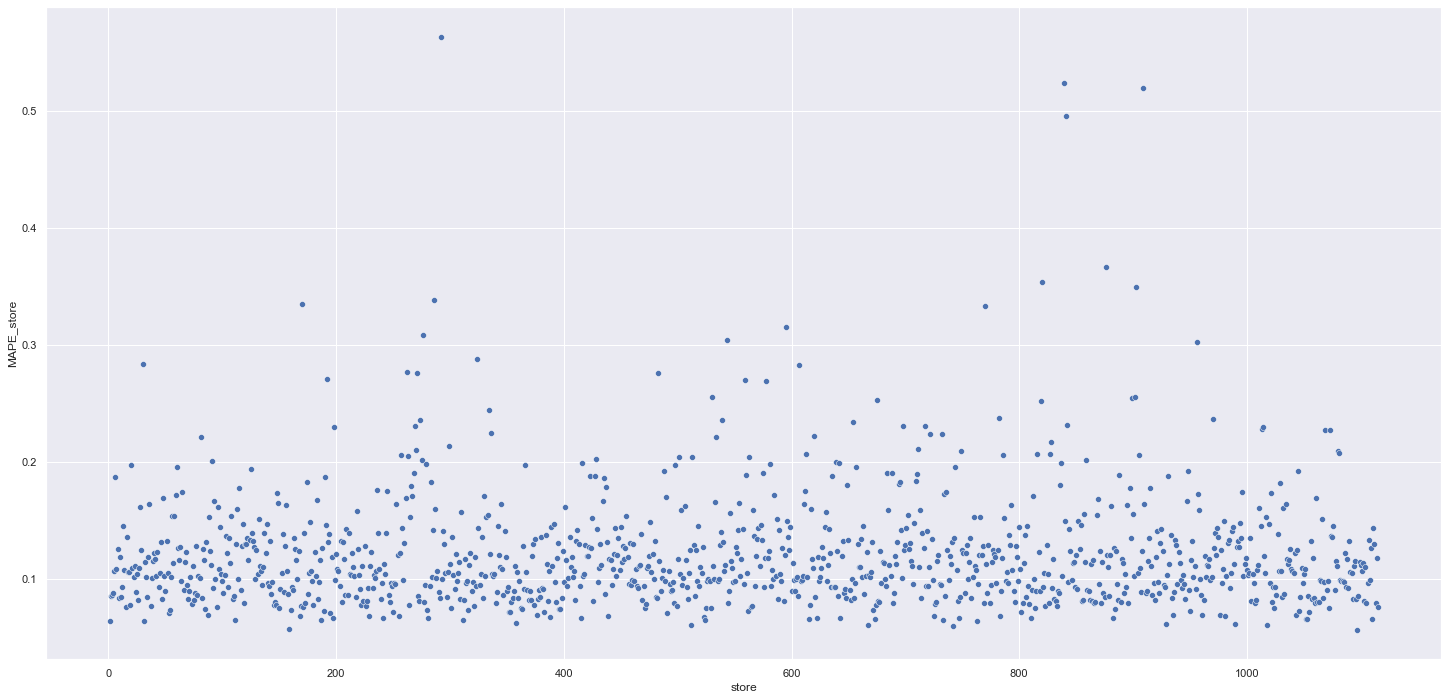

In [68]:
sns.scatterplot(data=predictions_by_store,x='store',y='MAPE_store')

## 10.2 Total Performance

In [69]:
pd.DataFrame(predictions_by_store.drop(columns=['store','MAPE_store']).sum()).T

,predictions,MAE_store,best_scenario,worst_scenario
0,"278,809,600.00","34,573,524.97","313,383,129.35","244,236,079.40"


## 10.3 Machine Learning Performance

In [70]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

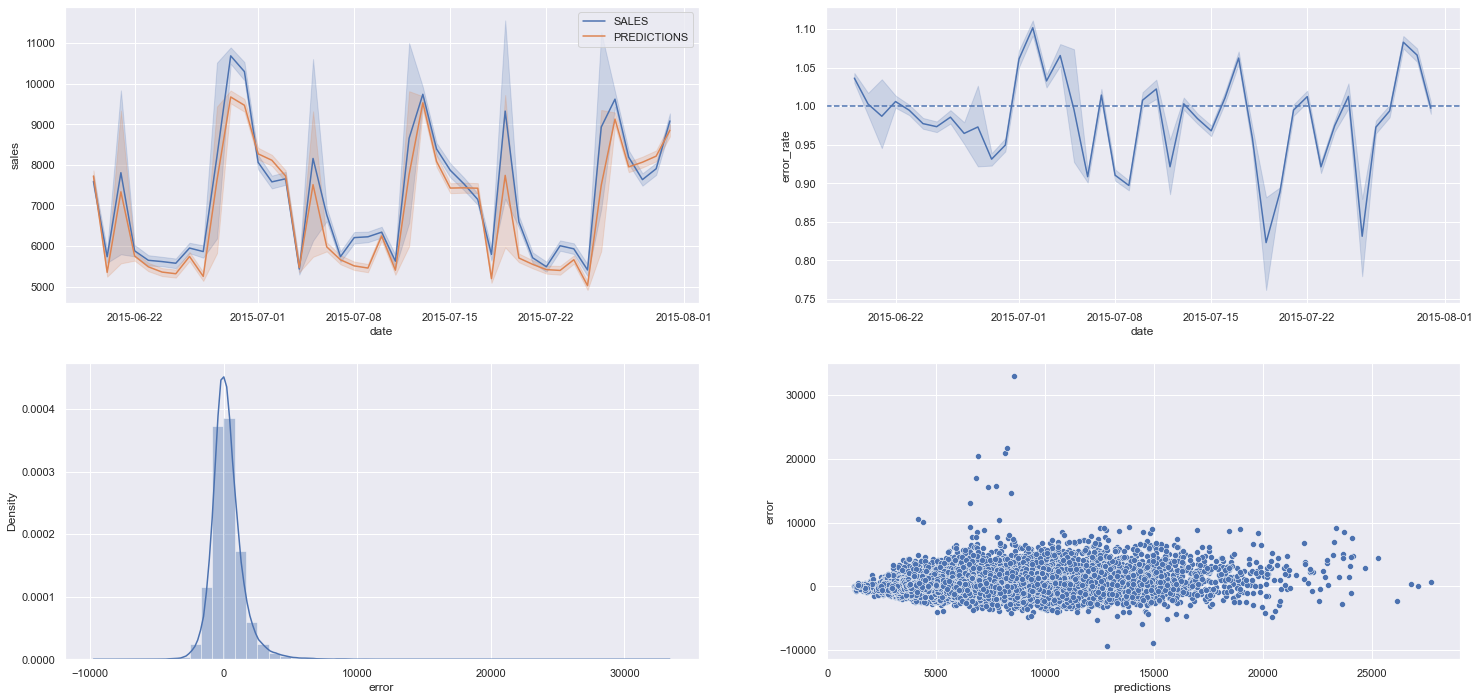

In [71]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df10, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df10, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df10 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df10['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df10['predictions'], df10['error'] )

# 11 DEPLOY MODEL TO PRODUCTION

## 11.1 Rossmann Class

In [101]:
import os
import inflection
import pandas as pd
import numpy as np
import datetime
import pickle

#Define the class that will be used for production

class sales_prediction():
    def __init__(self):
        self.home_path = os.get_cwd()
        self.competition_distance_scale =   pickle.load( open(os.path.join(self.home_path,'competition_distance_scale.pkl'), 'rb'))
        self.competition_open_since_scale = pickle.load( open(os.path.join(self.home_path,'competition_open_since_scale.pkl'), 'rb'))
        self.year_scale =                   pickle.load( open(os.path.join(self.home_path,'year_scale.pkl'), 'rb'))
        self.promo2_since_in_week_scale =   pickle.load( open(os.path.join(self.home_path,'promo2_since_in_week_scale.pkl'), 'rb'))
        self.store_type_encoder=            pickle.load( open(os.path.join(self.home_path,'store_type_encoder.pkl'), 'rb'))
    
    def cleaning(self, df):
        
        cols = df.columns
        snakecase_function = lambda x: inflection.underscore( x )
        cols_new = list( map(snakecase_function, cols) )
        df.columns = cols_new
        df = df.rename(columns={'promo_interval':'promo2_interval'})
        
        df['date'] = pd.to_datetime( df['date'] )
        
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 300000 if np.isnan( x ) else x )

        df['competition_open_since_month'] = df.apply( lambda x: x['date'].month 
                                                        if np.isnan(x['competition_open_since_month']) 
                                                        else x['competition_open_since_month'], axis=1)

        df['competition_open_since_year'] = df.apply( lambda x: x['date'].year 
                                                       if np.isnan(x['competition_open_since_year']) 
                                                       else x['competition_open_since_year'], axis=1)

        df['promo2_since_week'] = df.apply( lambda x: x['date'].week 
                                             if np.isnan(x['promo2_since_week']) 
                                             else x['promo2_since_week'], axis=1)

        df['promo2_since_year'] = df.apply( lambda x: x['date'].year 
                                             if np.isnan(x['promo2_since_year']) 
                                             else x['promo2_since_year'], axis=1)

        df['promo2_interval'].fillna(0, inplace=True)

        months = ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
        month_map = {i+1: months[i] for i in range(12)}

        df['date_month'] = df['date'].dt.month.map( month_map )

        df['is_promo2'] = df[['date_month', 'promo2_interval']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                                       1 if x['date_month'] in x['promo2_interval'].split(',') 
                                                                       else 0, axis=1 )
        
        df = df.astype( {'competition_open_since_month':'int64',
                         'competition_open_since_year':'int64',
                         'promo2_since_week':'int64',
                         'promo2_since_year':'int64'} )
        
        df = df[(df['open'] != 0) & (df['sales'] > 0)]
        
        cols_to_drop = ['customers', 'open', 'promo2_interval', 'date_month']

        df = df.drop(cols_to_drop, axis = 1)
        
        return df
        
        
    def feature_engineering(self, df):
        
        df['year'] = df['date'].dt.year

        df['day'] = df['date'].dt.day

        df['weekofyear'] = df['date'].dt.isocalendar().week

        df['month'] = df['date'].dt.month

        df['year_week'] = df['date'].dt.strftime( '%Y-%W' )

        df['competition_open_date'] = df[['competition_open_since_month', 'competition_open_since_year']].apply(
                                    lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

        df['competition_open_since'] = (df['date'] - df['competition_open_date']).dt.days

        df['promo2_since'] = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
        df['promo2_since'] = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df['promo2_since_in_week'] = ( ( df['date'] - df['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        return df
        
    def preparation(self, df):
        
        df['competition_distance'] =   self.competition_distance_scale.fit_transform( df[['competition_distance']].values )
        df['competition_open_since'] = self.competition_open_since_scale.fit_transform( df[['competition_open_since']].values )
        df['year'] =                   self.year_scale.fit_transform( df[['year']].values )
        df['promo2_since_in_week'] =   self.promo2_since_in_week_scale.fit_transform( df[['promo2_since_in_week']].values )
        
        df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )

        df['store_type'] = self.store_type_encoder.fit_transform( df['store_type'] )

        assortment_dict = {'basic': 1,  'extended': 2, 'extra': 3}
        df['assortment'] = df['assortment'].map( assortment_dict )

        df['sales'] = np.log1p( df['sales'] )

        df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        df['week_of_year_sin'] = df['weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df['week_of_year_cos'] = df['weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected_model =[ 'store',
                               'store_type',
                               'assortment',
                               'competition_distance',
                               'promo2',
                               'promo',
                               'competition_open_since',
                               'promo2_since_in_week',
                               'day_of_week_sin',
                               'day_of_week_cos',
                               'month_sin',
                               'month_cos',
                               'day_sin',
                               'day_cos',
                               'week_of_year_sin',
                               'week_of_year_cos',
                               'sales',
                               'date']
        
        return df[cols_selected_model]
    
    #data is what I receive from the user, data_to_predict is the transformed dataframe used for prediction    
    def get_prediction(self, model, data, data_to_predict):
        
        prediction         = model.predict( data_to_predict )
        data['prediction'] = np.expm1(prediction)
        
        return data.to_json( orient='records', date_format='iso' )

## 11.2 API Handler

In [103]:
from flask import Flask, request, Response
import pickle

model = pickle.load( open('model_xgb_trained.pkl', 'rb') )

app = Flask(__name__)

@app.route( '/sales_prediction/predict', methods=['POST'] )
def predict_sales():
    data_to_predict_json = request.get_json()
    
    if data_to_predict_json:
        if isinstance( test_json, dict ): # unique example
            raw_data = pd.DataFrame( data_to_predict_json, index=[0] )
            
        else: # multiple example
            raw_data = pd.DataFrame( data_to_predict_json, columns=data_to_predict_json[0].keys() )
            
        pipeline = Rossmann()
        
        # data cleaning
        df = pipeline.cleaning( raw_data )
        
        # feature engineering
        df = pipeline.feature_engineering( df )
        
        # data preparation
        df = pipeline.preparation( df )
        
        # prediction
        df_response = pipeline.get_prediction( model, raw_data, df )
        
        return df_response
    
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )
    

    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.15.15:5000/ (Press CTRL+C to quit)
192.168.15.15 - - [11/Sep/2021 20:03:31] "GET / HTTP/1.1" 404 -
192.168.15.15 - - [11/Sep/2021 20:03:31] "GET /favicon.ico HTTP/1.1" 404 -
192.168.15.15 - - [11/Sep/2021 20:03:37] "GET / HTTP/1.1" 404 -


## 11.3 API Tester

In [1]:
import requests
import pandas as pd
import json
import os

In [2]:
dfx = pd.read_csv('../data/test.csv')
df_raw_store = pd.read_csv('../data/store.csv', low_memory=False)
dfx_complete = pd.merge(df_raw_store, dfx, how='left', on='Store')

In [97]:
api_test_data = dfx_complete[dfx_complete['Store'] == 861]
api_test_data = api_test_data[api_test_data['Open'] != 0]
api_test_data = api_test_data[~api_test_data['Open'].isnull()] #there are some NaN in Open column to get rid off
api_test_data = api_test_data.drop('Id', axis=1)

In [98]:
data_to_api = json.dumps( api_test_data.to_dict( orient='records' ) )

In [109]:
for num in range(5):
    n = np.random.choice( dfx['Store'].unique() )
    
    api_test_data = dfx_complete[dfx_complete['Store'] == n]
    api_test_data = api_test_data[api_test_data['Open'] != 0]
    api_test_data = api_test_data[~api_test_data['Open'].isnull()] #there are some NaN in Open column to get rid off
    api_test_data = api_test_data.drop('Id', axis=1)
    
    data_to_api = json.dumps( api_test_data.to_dict( orient='records' ) )
    
    r = requests.post( 'https://rafael-sales-predictor.herokuapp.com/sales_prediction/predict', data=data_to_api, headers={'Content-type': 'application/json' } )
    value = pd.DataFrame(r.json())['prediction'].sum()
    
    print(f'Store {n} will sell {value:.2f} in next 6 weeks')

Store 378 will sell 282383.66 in next 6 weeks
Store 855 will sell 195964.93 in next 6 weeks
Store 41 will sell 252028.12 in next 6 weeks
Store 1086 will sell 189409.15 in next 6 weeks
Store 75 will sell 262399.41 in next 6 weeks


In [3]:
api_test_data = dfx_complete[dfx_complete['Store'] == 12 ]
api_test_data = api_test_data[api_test_data['Open'] != 0]
api_test_data = api_test_data[~api_test_data['Open'].isnull()] #there are some NaN in Open column to get rid off
api_test_data = api_test_data.drop('Id', axis=1)

data_to_api = json.dumps( api_test_data.to_dict( orient='records' ) )

r = requests.post( 'https://rafael-sales-predictor.herokuapp.com/sales_prediction/predict', data=data_to_api, headers={'Content-type': 'application/json' } )

In [7]:
r.json()

[{'store': 12,
  'store_type': 'a',
  'assortment': 'c',
  'competition_distance': 1070.0,
  'competition_open_since_month': None,
  'competition_open_since_year': None,
  'promo2': 1,
  'promo2_since_week': 13.0,
  'promo2_since_year': 2010.0,
  'promo_interval': 'Jan,Apr,Jul,Oct',
  'day_of_week': 4.0,
  'date': '2015-09-17',
  'open': 1.0,
  'promo': 1.0,
  'state_holiday': '0',
  'school_holiday': 0.0,
  'prediction': 8647.93359375},
 {'store': 12,
  'store_type': 'a',
  'assortment': 'c',
  'competition_distance': 1070.0,
  'competition_open_since_month': None,
  'competition_open_since_year': None,
  'promo2': 1,
  'promo2_since_week': 13.0,
  'promo2_since_year': 2010.0,
  'promo_interval': 'Jan,Apr,Jul,Oct',
  'day_of_week': 3.0,
  'date': '2015-09-16',
  'open': 1.0,
  'promo': 1.0,
  'state_holiday': '0',
  'school_holiday': 0.0,
  'prediction': 8719.5009765625},
 {'store': 12,
  'store_type': 'a',
  'assortment': 'c',
  'competition_distance': 1070.0,
  'competition_open_sin

In [112]:
pd.DataFrame(r.json())

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,day_of_week,date,open,promo,state_holiday,school_holiday,prediction
0,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",4.0,2015-09-17,1.0,1.0,0,0.0,7618.580078
1,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",3.0,2015-09-16,1.0,1.0,0,0.0,7686.885254
2,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2.0,2015-09-15,1.0,1.0,0,0.0,8213.112305
3,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1.0,2015-09-14,1.0,1.0,0,1.0,9619.494141
4,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",6.0,2015-09-12,1.0,0.0,0,0.0,6469.892090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,378,a,c,2140.0,8.0,2012.0,0,NaN,NaN,None,4.0,2015-08-06,1.0,1.0,0,1.0,7918.279785
118,378,a,c,2140.0,8.0,2012.0,0,NaN,NaN,None,3.0,2015-08-05,1.0,1.0,0,1.0,8022.885742
119,378,a,c,2140.0,8.0,2012.0,0,NaN,NaN,None,2.0,2015-08-04,1.0,1.0,0,1.0,8714.562500
120,378,a,c,2140.0,8.0,2012.0,0,NaN,NaN,None,1.0,2015-08-03,1.0,1.0,0,1.0,10283.496094


In [28]:
def load_dataset( store_id ):
    
    dfx = pd.read_csv('./test.csv')
    df_raw_store = pd.read_csv('./store.csv', low_memory=False)
    dfx_complete = pd.merge(df_raw_store, dfx, how='left', on='Store')
       
    api_test_data = dfx_complete[dfx_complete['Store'] == store_id ]
    
    if not api_test_data.empty:
    
        api_test_data = api_test_data[api_test_data['Open'] != 0]
        api_test_data = api_test_data[~api_test_data['Open'].isnull()] #there are some NaN in Open column to get rid off
        api_test_data = api_test_data.drop('Id', axis=1)

        data_to_api = json.dumps( api_test_data.to_dict( orient='records' ) )

    else:
        data_to_api = 'error'
        
    return data_to_api, dfx_complete

In [29]:
df1, dfx_complete = load_dataset(12)

In [20]:
r = requests.post( 'https://rafael-sales-predictor.herokuapp.com/sales_prediction/predict', data=df1, headers={'Content-type': 'application/json' } )

In [24]:
r.json()[0]

{'store': 12,
 'store_type': 'a',
 'assortment': 'c',
 'competition_distance': 1070.0,
 'competition_open_since_month': None,
 'competition_open_since_year': None,
 'promo2': 1,
 'promo2_since_week': 13.0,
 'promo2_since_year': 2010.0,
 'promo_interval': 'Jan,Apr,Jul,Oct',
 'day_of_week': 4.0,
 'date': '2015-09-17',
 'open': 1.0,
 'promo': 1.0,
 'state_holiday': '0',
 'school_holiday': 0.0,
 'prediction': 8647.93359375}

In [35]:
dfx_complete[dfx_complete['Store'] == int('65') ]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Id,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
2320,65,a,c,13840.0,5.0,2010.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN,NaN,NaN,NaN
